# Stex

In [1]:
import pickle
import pandas as pd

In [2]:
# load stex
# stex = pd.read_pickle('derived_data/stex.pkl')

# load hlrc
with open('derived_data/hlrc.pkl', 'rb') as f:
    hlrc = pickle.load(f)
    
# load hfrc
with open('derived_data/hfrc.pkl', 'rb') as f:
    hfrc = pickle.load(f)
    
# load site label
labels = []
with open("../../data/raw/stex/stex_site_id.txt", "r") as f:
    for line in f:
        idx, label = line.strip().split("\t")
        labels.append(label)

## KPCA

In [3]:
import glob
import re

import numpy as np
import pandas as pd
from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import scale
import pymp

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'savefig.bbox': 'tight',
    'savefig.transparent':True})

def pmap(f, x, num_threads):
    y = pymp.shared.list([None] * len(x))
    with pymp.Parallel(num_threads) as p:
        for i in p.range(len(x)):
            y[i] = f(x[i])
    return list(y)

def _binning(C, bins):
    def H(c):
        h = np.histogram(c, bins)[0]
        return h / sum(h)

    return list(pmap(H, C, 64))


def horc_histogram(C):
    return _binning(C, [x / 100 for x in range(-200, 104, 5)])

def hlrc_histogram(C):
    return _binning(C, [x / 100 for x in range(-100, 104, 5)])


def kpca(histogram, k):
    pca = KernelPCA(n_components=k, kernel="precomputed", tol=1e-5, max_iter=2000)
    D = rbf_kernel(histogram)
    embedding = pca.fit_transform(D)
    
    return embedding

In [35]:
def plot_embed(embedding, labels, fig_output = None):
    language = ['japanese', "chinese", 'italian', 'spanish', 'french', 'german', 'english', 'korean', 'rus', 'esperanto', 'conlang', 'latin', 'ukrainian', 'korean']
    religions = ['islam', 'hinduism', 'buddhism', 'judaism', 'christianity']
    nerds = ['rpg', 'scifi', 'boardgames', 'anime', 'gaming']
    
    religion_idx = [i for i, lbl in enumerate(labels) if lbl in religions]
    language_idx = [i for i, lbl in enumerate(labels) if lbl in language]
    nerds_idx = [i for i, lbl in enumerate(labels) if lbl in nerds]
  
    x = embedding[:, 0]
    y = embedding[:, 1]

    plt.figure(figsize=(4, 4))
    if religion_idx:
        plt.scatter(x[religion_idx], y[religion_idx], alpha=1, 
                    marker='^', color='#c1272d',label='Religion')
    if language_idx:
        plt.scatter(x[language_idx], y[language_idx], alpha=1,
                    marker='*', color='#114684',label="Language")
    if nerds_idx:
        plt.scatter(x[nerds_idx], y[nerds_idx], alpha=1,
                    marker='o', color='#d4872f',label="Nerds")

    for i, label in enumerate(labels):
        if label in religions:
            txt_color = '#c1272d'
        elif label in language:
            txt_color = '#114684'
        elif label in nerds:
            txt_color = '#d4872f'
        else: continue
        
        plt.annotate(label,
                    (x[i], y[i]),
                    textcoords="offset points",  # position relative to the point
                    xytext=(5, -2.5),               # offset in points
                    fontsize=8,
                    color=txt_color)
    if fig_output:
        plt.savefig(fig_output)
    plt.legend()
    plt.show()

    religion_embed = embedding[religion_idx,:]
    language_embed = embedding[language_idx,:]
    nerds_embed = embedding[nerds_idx,:]
    horc_node_embed = np.concatenate([religion_embed, language_embed, nerds_embed], axis=0)

    # true label
    religion_labels = np.zeros(len(religion_embed), dtype=int)
    language_labels = np.ones(len(language_embed), dtype=int)
    nerds_labels = np.full(len(nerds_embed), 2, dtype=int)
    node_labels = np.concatenate([religion_labels, language_labels, nerds_labels], axis=0)

    # kmeans
    kmeans = KMeans(n_clusters=3, random_state=42)
    predicted_labels = kmeans.fit_predict(horc_node_embed)

    # Compute the Adjusted Rand Index (ARI)
    ari_score = adjusted_rand_score(node_labels, predicted_labels)
    ami_score = adjusted_mutual_info_score(node_labels, predicted_labels)
    print("Adjusted Rand Index (ARI):", ari_score)
    print("Adjusted Mutual Info. (AMI):", ami_score)

### HLRC

In [31]:
hlrc_embed = kpca(hlrc_histogram(hlrc), 2)

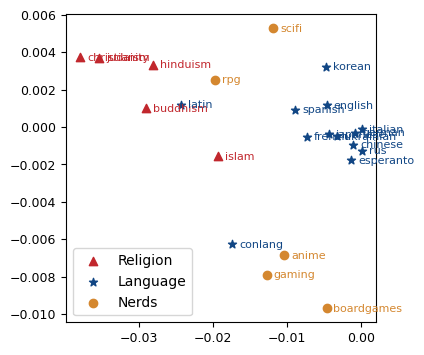

Adjusted Rand Index (ARI): 0.5358727193889463
Adjusted Mutual Info. (AMI): 0.43814336954114547


In [36]:
plot_embed(hlrc_embed, labels, fig_output = "figures/Stex_HLRC_kpca.pdf")

## Histogram Plot

In [4]:
len(hlrc)

355